In [1]:

import sys
import os

# Get the current directory
current_directory = os.getcwd()

# Add the current directory to the Python path
sys.path.append(current_directory)
print(current_directory)
from spectraltools import Specimen_Collection, Spectrum, create_path_if_not_exists
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import math
import re
import scipy


C:\Users\esteb\cicima\escarabajos\gamma


In [2]:

import tensorflow as tf

In [3]:

"""This section allows the user to choose their workplace location.
This is important if the user has multiple locations and operating systems in which this 
script is run"""

#select location
working_at = "wfh"

#Training data is used when we are already certain of species and genera for a particular sample
training_data_is_used = False

if working_at == "colaboratory":
  from google.colab import drive
  drive.mount("/content/drive")
  #base folder
  """Select the location for your base folder"""
    
  base_folder = r"/content/drive/My Drive/CICIMA/escarabajos_files"
  
elif working_at == "wfh":

    """Select the location of your base folder"""
    base_folder = r"C:\Users\esteb\cicima\escarabajos"

elif working_at == "cicima_desktop":
  
    """Select the location of your base folder"""
    base_folder = r"C:\Users\EstebanSoto\Jupyter\escarabajos"

elif working_at == "cicima_laptop":
    
    """Select the location of your base folder"""
    base_folder = r"/home/vinicio/escarabajos"

#define the location of the tables with information about the collections and its parent directory

collection_tables_main_path =  os.path.join(base_folder, "L1050_data","collections")
collection_files_main_path = os.path.join(base_folder, "L1050_data")

# Define report location
report_location = os.path.join(base_folder, "reports","data_analysis")

#collection_descriptor = r"CICIMAUCR and ANGSOL" tododelete

#File location and metadata location for collection 1
angsol_collection_path = os.path.join(collection_files_main_path,"ANGSOL","average") 
angsol_collection_metadata = os.path.join(collection_tables_main_path,"CICIMA-beetles-general-inventory - ANGSOL.txt") 

#File location and metadata location for collection 2
cicimaucr_collection_path = os.path.join(collection_files_main_path,r"TRA_data_CICIMA_INBUCR","CICIMAUCR","reflectance")  #listo
cicimaucr_collection_2_path = os.path.join(collection_files_main_path,r"CICIMA-2024-01-REFLECTANCE","average")
cicimaucr_collection_3_path = os.path.join(collection_files_main_path,r"CICIMA-2024-03-REFLECTANCE","without iris nor lens","average")
cicima_ucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - CICIMAUCR.txt") 

#File location and metadata location for collection 3
inbucr_collection_path = os.path.join(collection_files_main_path,r"INBUCR","average") #listo
inbucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - INBUCR.txt") 

#File location and metadata location for collection 4
bioucr_collection_path = os.path.join(collection_files_main_path,r"BIOUCR","average")  #listo
bioucr_metadata = os.path.join(collection_tables_main_path,r"CICIMA-beetles-general-inventory - BIOUCR.txt") 

#agregated data location, here averages and std will be saved when training data and retreived when classifying spectra
agregated_data_location = os.path.join(base_folder, "agregated_data")
agregated_data_avg_path = os.path.join(agregated_data_location,"peak_averages_krc.txt" )  #listo
agregated_data_std_path  = os.path.join( agregated_data_location , r"peak_std_krc.txt") #listo




In [4]:

#Collections
angsol_collection = Specimen_Collection("ANGSOL", angsol_collection_path, angsol_collection_metadata, "HIGH")
angsol_collection.set_description("ANGSOL collection has specimens that belong to Angel Solís. The confidence that we have about specimen identification is high.")

cicimaucr_collection = Specimen_Collection("CICIMAUCR1", cicimaucr_collection_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_2 = Specimen_Collection("CICIMAUCR2", cicimaucr_collection_2_path, cicima_ucr_metadata, "HIGH")
cicimaucr_collection_3 = Specimen_Collection("CICIMAUCR3", cicimaucr_collection_3_path, cicima_ucr_metadata, "HIGH")
inbucr_collection = Specimen_Collection("INBUCR", inbucr_collection_path, inbucr_metadata, "MID")
bioucr_collection = Specimen_Collection("BIOUCR", bioucr_collection_path, bioucr_metadata, "LOW")

collection_list = [
                    angsol_collection,
                    cicimaucr_collection,
                    cicimaucr_collection_2,
                    cicimaucr_collection_3,
                    inbucr_collection,
                    #bioucr_collection,
                    ]
collection_names_set = set([collection.name for collection in collection_list])
collection_names = " ".join( sorted(collection_names_set))
#print(collection_names)
#date
from datetime import datetime
current_date = datetime.now().date()

In [5]:
def get_filtered_spectra(collection_list):

    all_spectra = []
    
    for collection in collection_list:
        all_spectra += collection.get_spectra()

    all_spectra = [item for item in all_spectra if item.get_species() in ["kalinini", "resplendens", "cupreomarginata"]]
    return all_spectra
    
all_spectra = get_filtered_spectra(collection_list)

for spectrum in all_spectra:
    print(spectrum.get_species())

resplendens
kalinini
cupreomarginata
kalinini
resplendens
kalinini
cupreomarginata
kalinini
kalinini
kalinini
kalinini
cupreomarginata
resplendens
cupreomarginata
resplendens
cupreomarginata
cupreomarginata
resplendens
resplendens
resplendens
resplendens
kalinini
cupreomarginata
cupreomarginata
resplendens
resplendens
resplendens
resplendens
kalinini
kalinini
kalinini
cupreomarginata
resplendens
cupreomarginata


In [6]:
class Metric():
    """This is an abstract class that represents every metric, allows it to be compared, have a description and a name.
    This is useful when using it in the report methods """
    name = "Metric"
    
    def get_metric_value(self, spectrum):
        metric_value = None
        return metric_value

    def __init__(self, spectrum):
        
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)
        
    @classmethod
    def get_name(cls):
        return cls.name

    @staticmethod
    def description():
        return "No description yet"

    def __lt__(self, other):
        return self.metric_value < other.metric_value

    def __repr__(self):
        return f'{self.name} value: {self.metric_value:.4f} for {self.spectrum.genus} {self.spectrum.species}. File: {self.spectrum.filename}'

In [7]:
class Gamma_Arbitrary_Limits(Metric):
    """This gamma metric calculates the ratio between the maximum in the IR range and the maximum in the visible range. Ranges are static."""
    uv_vis_min_wavelength, uv_vis_max_wavelength = 250.00, 1000.00
    ir_min_wavelength = uv_vis_max_wavelength
    ir_max_wavelength = 2500.00
        
    def get_metric_value(self, spectrum):
        def get_maximum_in_range(spectrum, min_wavelength, max_wavelength):
            measuring_mode = spectrum.metadata["measuring_mode"]
            df = spectrum.data
            max_value = df[(df["wavelength"] > min_wavelength) & (df["wavelength"]  < max_wavelength) ].max()
            #print(f"max value \n {max_value}")
            wavelength, measure = max_value["wavelength"], max_value[measuring_mode]
            return wavelength, measure

        uv_vis_wavelength, uv_vis_max = get_maximum_in_range(spectrum, Gamma_Arbitrary_Limits.uv_vis_min_wavelength, Gamma_Arbitrary_Limits.uv_vis_max_wavelength)
        ir_wavelength, ir_max = get_maximum_in_range(spectrum, Gamma_Arbitrary_Limits.ir_min_wavelength, Gamma_Arbitrary_Limits.ir_max_wavelength)
        metric_value = (uv_vis_max / ir_max)*1.00
        
        return metric_value

    def __init__(self, spectrum):
        self.name = "Gamma_Arbitrary_Limits"
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)

    
    @staticmethod
    def description():
        return f"""This algorithm calculates the ratio between the highest reflectance peak in the visible range (Between {Gamma_Arbitrary_Limits.uv_vis_min_wavelength} nm and {Gamma_Arbitrary_Limits.uv_vis_max_wavelength} nm)
                and the maximum peak in the IR range up to {Gamma_Arbitrary_Limits.ir_max_wavelength} nm. Beyond {Gamma_Arbitrary_Limits.ir_max_wavelength} nm the internal structure's reflectance generates unwanted noise."""
    def __repr__(self):
        return f'Gamma arbitrary limits, value: {self.metric_value:.4f} for {self.spectrum.genus} {self.spectrum.species}. File: {self.spectrum.filename}'

In [8]:
def feature_and_label_extractor(Metric, spectra):
    features = []
    labels = []
    codes = []
    #get code, label and feature for each spectrum
    for spectrum in spectra:
        feature = Metric(spectrum).metric_value
        label = spectrum.get_species()
        code = spectrum.code
        codes.append(code)
        features.append(feature)
        labels.append(label)
        
    data = [codes, features, labels]
    
    return data
    
gamma_arbitrary_limits_data = feature_and_label_extractor(Gamma_Arbitrary_Limits, all_spectra)

print(gamma_arbitrary_limits_data)

[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], [1.1390146104902408, 1.3409670513383083, 1.0164551657219798, 1.109831303736163, 2.0755763900804234, 1.7943288119666445, 2.772034742016151, 1.3014573614342573, 1.1896884990864263, 1.410737334581443, 1.296730635422952, 0.8995225575899621, 1.2487951339142065, 1.063095313644834, 1.2817050686153044, 1.1056884158263969, 0.9708377102342364, 1.203868330470921, 1.1233170507918933, 1.0406884259840539, 1.1510013026401675, 1.4665417599038804, 1.

In [9]:
class Gamma_First_Two_Peaks(Metric):
    """This gamma metric calculates the ratio between the second and first peak."""
    name = "Gamma_First_Two_Peaks"
    
    def get_metric_value(self, spectrum):
        #get list of maxima and minima
        max_i, max_x, max_y = spectrum.get_maxima()
        #Divide second peak over first peak
        metric_value = max_y[1]/max_y[0]
        return metric_value

    def __init__(self, spectrum):
        
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)

    @staticmethod
    def description():
        return f"""This algorithm calculates the ratio between the second and first reflectance peak."""

    def __repr__(self):
        return f'Gamma first two peaks {self.metric_value:.4f} for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'

In [10]:
gamma_first_two_peaks_data = feature_and_label_extractor(Gamma_First_Two_Peaks, all_spectra)

print(gamma_first_two_peaks_data)

[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], [0.929661563053092, 1.5175798096006232, 1.195023840653329, 1.3002852294600524, 1.061263556672878, 1.2894620099264786, 0.856289595722265, 1.3487478209551182, 1.6205813522532078, 1.2985383862885052, 1.2139860804964966, 1.0667915598213058, 0.8372564874132148, 1.111391756407424, 0.8457720943792515, 1.0348773578829509, 1.0424622283857201, 1.0326184007344061, 1.0220626221296782, 1.4105400676306972, 1.0897341262031397, 1.3185770757936115, 1

In [11]:
class Gamma_Area_Under_Curve_Naive(Metric):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_start_wavelength = 450
    visible_end_wavelength = ir_start_wavelength = 800
    ir_end_wavelength = 1500
    name = "Gamma_Area_Under_Curve_Naive"
    
    def __init__(self, spectrum):
        
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)
        
   
    def description():
        return f"""This method calculates the ratio between the area under the curve for the spectrum between {Gamma_Area_Under_Curve_Naive.visible_start_wavelength} 
        and {Gamma_Area_Under_Curve_Naive.visible_end_wavelength} nm (visible range) and between {Gamma_Area_Under_Curve_Naive.ir_start_wavelength} nm and 
        {GammaAreaUnderCurveNaive.ir_end_wavelength} nm (infrared range)."""


    def get_metric_value(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            #print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np
        df = spectrum.get_normalized_spectrum()
        area_uv_visible = get_area_under_curve(spectrum, Gamma_Area_Under_Curve_Naive.visible_start_wavelength, Gamma_Area_Under_Curve_Naive.visible_end_wavelength)
        area_ir = get_area_under_curve(spectrum, Gamma_Area_Under_Curve_Naive.ir_start_wavelength, Gamma_Area_Under_Curve_Naive.ir_end_wavelength)
        metric = area_ir/area_uv_visible
        return metric


In [12]:
gamma_area_under_curve_data = feature_and_label_extractor(Gamma_Area_Under_Curve_Naive, all_spectra)

print(gamma_area_under_curve_data)

[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], [2.4134211103697703, 2.3558071657223727, 2.918655724284975, 2.5427267910470777, 1.2567475918486348, 1.554137281793946, 1.0513483788843936, 2.0895374419092754, 2.140540182188479, 1.5816506302100886, 1.878028224357104, 2.34890739705099, 1.8321746323396646, 2.6205330312462163, 1.8210753753666744, 2.1795466880212833, 2.4159704627194802, 1.9219671348922627, 2.04787022909593, 3.174553174285849, 2.001549399425923, 2.0282075671901008, 2.0091

In [13]:
class  Gamma_Area_Under_Curve_First_Min_Cut(Metric):
    #this is a subclass of Gamma
    #get_gamma_factor must be redefined
    visible_range_start_wavelength = 450
    name = "gamma_area_under_curve_cut_first_minimum"

    def __init__(self, spectrum):
        
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)
        
    def description():
        return f"""This algorithm calculates the area for the visible region (starting at {Gamma_Area_First_Min_Cut.visible_range_start_wavelength} 
        and ending in the first minima between the maximum in the visible range and the maximum in the IR range. 
        Then calculates the area of the IR range up to the second minumum. The ratio between these two areas is the gamma value."""

    def get_metric_value(self, spectrum):

        def get_area_under_curve(spectrum, start_wavelength, finish_wavelength):
            # Assuming your DataFrame is named df and has columns 'wavelength' and 'height'
            # Let's say you have start_wavelength and finish_wavelength variables for the range you want to integrate over
            # Subset the DataFrame to the range of interest
            subset_df = df[(df['wavelength'] >= start_wavelength) & (df['wavelength'] <= finish_wavelength)]

            # Extract the wavelengths and heights as arrays
            wavelengths = subset_df['wavelength'].values
            heights = subset_df[spectrum.measuring_mode].values

            # Calculate the area under the curve using the trapezoidal rule
            area_under_curve = np.trapz(heights, wavelengths)

            # print("Area under the curve:", area_under_curve)
            return area_under_curve

        import numpy as np

        #test_spectrum = filtered_spectra[0]
        #get the highest data recorded
        max_value = spectrum.data[spectrum.measuring_mode].max()
        #get maxima and minima
        x = spectrum.data["wavelength"].values
        y = spectrum.data[spectrum.measuring_mode].values

        #get x and y positions of maxima and minima
        max_i, max_xs, max_ys = spectrum.get_maxima()
        min_i, min_xs, min_ys= spectrum.get_minima()

        #get x locations of first and second maxima and the minimum in between
        first_max_x = max_xs[0]
        try:
            second_max_x = max_xs[1]
        except Exception as e:
            second_max_x = x.max()
            print(e)
        try:
            second_max_y = max_ys[1]
        except Exception as e:
            second_max_y = 0
            print(e)

        min_in_between_i = 0
        min_in_between_x =0
        min_in_between_y =0
        #get the location of the minimum in between
        for index in min_i:
            #print("index")
            if first_max_x <= x[index] <= second_max_x:
                min_in_between_i = index
                min_in_between_x = x[index]
                min_in_between_y = y[index]
                break

        # print(f"min in bet: {min_in_between_i} {min_in_between_x} {min_in_between_y} ")
        #second minimum
        #get the location of the second minimum
        min_after_second_max_i = 0
        min_after_second_max_x = 0
        min_after_second_max_y = 0
        for index in min_i:
            # print(f" second_max_x  <= x[index] { second_max_x  <= x[index]}")
            if second_max_x  <= x[index]:
                min_after_second_max_i = index
                min_after_second_max_x = x[index]
                min_after_second_max_y = y[index]
                break


        # print(f"min after: {min_after_second_max_i} {min_after_second_max_x} {min_after_second_max_y} ")

        x_values = [first_max_x, min_in_between_x, second_max_x, min_after_second_max_x]
        y_values = [max_ys[0]/max_value, min_in_between_y/max_value, second_max_y/max_value, min_after_second_max_y/max_value]
        #get the normalized spectrum
        df = spectrum.get_normalized_spectrum()
        #plot
        x = df["wavelength"].values
        y =df[spectrum.measuring_mode].values

        #modify y to have last value equal to first one
        y_mod = y
        y_mod[-1] = y_mod[0]
        
        #split x, y LEFT
        #print(f"fmi: {min_in_between_i}")
        x_left = x[:min_in_between_i]
        y_left = y[:min_in_between_i]
        #set last one to zero for picture to be displaye properly
        y_left[-1] = y_left[0]
        

        #split x, y RIGHT
        #print(f"min_after_second_max_i: {min_after_second_max_i}")
        x_right = x[min_in_between_i:min_after_second_max_i]
        y_right = y[min_in_between_i:min_after_second_max_i]
        #set last one to zero for picture to be displaye properly
        y_right[0] = y_right[-1] = y_left[0]
        
        #show figure

        area_uv_visible = get_area_under_curve(spectrum, Gamma_Area_Under_Curve_First_Min_Cut.visible_range_start_wavelength, min_in_between_x)
        area_ir = get_area_under_curve(spectrum, min_in_between_x, min_after_second_max_x)
        gamma = area_ir/area_uv_visible
        #print(f"gamma: {gamma}")
        return gamma


In [14]:
gamma_area_under_curve_first_min_cut_data = feature_and_label_extractor(Gamma_Area_Under_Curve_First_Min_Cut, all_spectra)

print(gamma_area_under_curve_first_min_cut_data)

[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], [1.994419805270542, 2.964096619011071, 3.5575606302526923, 3.244327436653907, 1.8487346529862647, 2.398936136980146, 2.065102740400307, 2.72266126355502, 3.7339938116618185, 2.1872575935743135, 2.675912417098908, 4.225425969369175, 1.3478412163395006, 3.4489975240544797, 1.2057966549033334, 4.432982740612728, 4.327138074879682, 2.164324081429403, 2.532134147040601, 4.193066779604817, 2.067189956788224, 2.4383264969161824, 3.974317004

In [15]:
class Gamma_Vector_Relative_Reflectance(Metric):
    """This gamma metric calculates a vector with all the relative heights with respect to the first peak."""
    name = "Gamma_Vector_Relative_Reflectance"
    
    def get_metric_value(self, spectrum):
        #get list of maxima and minima
        max_i, max_x, max_y = spectrum.get_maxima()
        
        #Divide every peak over first peak
        metric_value = list(max_y/max_y[0])
        return metric_value

    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)

    @staticmethod
    def description():
        return f"""This gamma metric calculates a vector with all the relative heights with respect to the first peak"""

    def __repr__(self):
        return f'Gamma vector relative reflectance: {self.metric_value} for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'

In [16]:
gamma_vector_relative_reflectance_data = feature_and_label_extractor(Gamma_Vector_Relative_Reflectance, all_spectra)

print(gamma_vector_relative_reflectance_data)


[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], [[1.0, 0.929661563053092, 0.8779518636460617, 0.8424448622031562, 0.575054029919288, 0.5182256019889586], [1.0, 1.5175798096006232, 1.1146181236697699, 0.8133065410248089, 0.7362709794301819], [1.0, 1.195023840653329, 1.1756778665240128, 1.135094465948271, 0.8112085939294132, 0.7337734252622663], [1.0, 1.3002852294600524, 1.1716061937365982, 1.1701884498106103, 0.7607623848870876, 0.6680365942094596], [1.0, 1.061263556672878, 0.44042

In [17]:
def pad_list(lst, filler=0):
    metrics = lst[1]
    
    for metric in metrics:
        #print(metric)
        
        max_length = max([len(list) for list in metrics])
        
        #print(max_length)
        
        padded_list = []

        for element in metrics:

            padded_sublist = element
            
            padded_sublist += [filler] * (max_length - len(padded_sublist))
            padded_list.append(padded_sublist)
            #print(padded_sublist)
    final_list = [lst[0], np.array(padded_list), lst[2]]
    return final_list

pad_list(gamma_vector_relative_reflectance_data)

[['ANGSOL0011',
  'ANGSOL0012',
  'ANGSOL0013',
  'ANGSOL0017',
  'CICIMAUCR0104',
  'CICIMAUCR0105',
  'CICIMAUCR0158',
  'CICIMAUCR0001',
  'CICIMAUCR0006',
  'CICIMAUCR0008',
  'CICIMAUCR0009',
  'CICIMAUCR0012',
  'CICIMAUCR0013',
  'CICIMAUCR0014',
  'CICIMAUCR0015',
  'CICIMAUCR0018',
  'CICIMAUCR0019',
  'CICIMAUCR0020',
  'CICIMAUCR0021',
  'CICIMAUCR0070',
  'CICIMAUCR0071',
  'CICIMAUCR0097',
  'CICIMAUCR0098',
  'CICIMAUCR0100',
  'CICIMAUCR0101',
  'CICIMAUCR0104',
  'CICIMAUCR0108',
  'CICIMAUCR0112',
  'CICIMAUCR0113',
  'CICIMAUCR0116',
  'CICIMAUCR0141',
  'CICIMAUCR0158',
  'INBUCR0426',
  'INBUCR0433'],
 array([[1.        , 0.92966156, 0.87795186, 0.84244486, 0.57505403,
         0.5182256 , 0.        , 0.        , 0.        ],
        [1.        , 1.51757981, 1.11461812, 0.81330654, 0.73627098,
         0.        , 0.        , 0.        , 0.        ],
        [1.        , 1.19502384, 1.17567787, 1.13509447, 0.81120859,
         0.73377343, 0.        , 0.        , 0. 

In [18]:
class Wavelength_Vector(Metric):
    """This gamma metric calculates a vector with each peak's wavelength."""
    name = "Wavelength_Vector"
    
    def get_metric_value(self, spectrum):
        #get list of maxima and minima
        max_i, max_x, max_y = spectrum.get_maxima()
        
        #Divide every peak over first peak
        metric_value = list(max_x)
        return metric_value

    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)

    @staticmethod
    def description():
        return f"""This metric calculates a vector with each peak's wavelength."""

    def __repr__(self):
        return f'Vector wavelength : {self.metric_value} for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'

In [19]:
wavelength_vector_data = feature_and_label_extractor(Wavelength_Vector, all_spectra)

#print(wavelength_vector_data)

data = pad_list(wavelength_vector_data)
print(data)

[['ANGSOL0011', 'ANGSOL0012', 'ANGSOL0013', 'ANGSOL0017', 'CICIMAUCR0104', 'CICIMAUCR0105', 'CICIMAUCR0158', 'CICIMAUCR0001', 'CICIMAUCR0006', 'CICIMAUCR0008', 'CICIMAUCR0009', 'CICIMAUCR0012', 'CICIMAUCR0013', 'CICIMAUCR0014', 'CICIMAUCR0015', 'CICIMAUCR0018', 'CICIMAUCR0019', 'CICIMAUCR0020', 'CICIMAUCR0021', 'CICIMAUCR0070', 'CICIMAUCR0071', 'CICIMAUCR0097', 'CICIMAUCR0098', 'CICIMAUCR0100', 'CICIMAUCR0101', 'CICIMAUCR0104', 'CICIMAUCR0108', 'CICIMAUCR0112', 'CICIMAUCR0113', 'CICIMAUCR0116', 'CICIMAUCR0141', 'CICIMAUCR0158', 'INBUCR0426', 'INBUCR0433'], array([[ 614.,  830., 1126., 1308., 1659., 1855.,    0.,    0.,    0.],
       [ 587.,  802., 1316., 1653., 1855.,    0.,    0.,    0.,    0.],
       [ 607.,  934., 1130., 1292., 1656., 1816.,    0.,    0.,    0.],
       [ 578.,  815., 1134., 1319., 1656., 1862.,    0.,    0.,    0.],
       [ 586.,  755., 1385.,    0.,    0.,    0.,    0.,    0.,    0.],
       [ 586.,  776., 1396., 1668.,    0.,    0.,    0.,    0.,    0.],
     

In [20]:
class Critical_Points(Metric):
    """This metric returns a vector with each critical point wavelength and relative reflectance."""
    name = "Critical_Points"
    
    def get_metric_value(self, spectrum):
       
        #get list of maxima and minima
        #crit_i, crit_x, crit_y = 
        
        peaks = spectrum.get_critical_points()
        metric_value = [list(element) for element in peaks]
        #first maximum is metric_value[0][1]
        first_max = metric_value[0][1]
        metric_value = [obj/first_max for obj in metric_value]
        return metric_value
     

    def __init__(self, spectrum):
        self.spectrum = spectrum
        self.metric_value = self.get_metric_value(spectrum)

    @staticmethod
    def description():
        return f"""This metric returns a vector with each critical point wavelength and relative reflectance."""

    def __repr__(self):
        return f'Critical_Points : {self.metric_value} for {self.spectrum.genus} {self.spectrum.species} in {self.spectrum.filename}'

In [21]:
critical_points_data = feature_and_label_extractor(Critical_Points, all_spectra)

#print(critical_points_data)
pad_list(critical_points_data, filler = np.array([0,0]))


[['ANGSOL0011',
  'ANGSOL0012',
  'ANGSOL0013',
  'ANGSOL0017',
  'CICIMAUCR0104',
  'CICIMAUCR0105',
  'CICIMAUCR0158',
  'CICIMAUCR0001',
  'CICIMAUCR0006',
  'CICIMAUCR0008',
  'CICIMAUCR0009',
  'CICIMAUCR0012',
  'CICIMAUCR0013',
  'CICIMAUCR0014',
  'CICIMAUCR0015',
  'CICIMAUCR0018',
  'CICIMAUCR0019',
  'CICIMAUCR0020',
  'CICIMAUCR0021',
  'CICIMAUCR0070',
  'CICIMAUCR0071',
  'CICIMAUCR0097',
  'CICIMAUCR0098',
  'CICIMAUCR0100',
  'CICIMAUCR0101',
  'CICIMAUCR0104',
  'CICIMAUCR0108',
  'CICIMAUCR0112',
  'CICIMAUCR0113',
  'CICIMAUCR0116',
  'CICIMAUCR0141',
  'CICIMAUCR0158',
  'INBUCR0426',
  'INBUCR0433'],
 array([[[27.73081204,  1.        ],
         [37.48627686,  0.92966156],
         [50.8548768 ,  0.87795186],
         ...,
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ]],
 
        [[38.07027669,  1.        ],
         [52.01424516,  1.51757981],
         [85.35005814,  1.11461812],
         ...,
       

## Averages

In [22]:
#Saving_averages is True only with trusty spectra
saving_averages = True
#This class gets the average and standard deviation per species for a particular Gamma class
def get_gamma_avg_and_std(Metric,filtered_spectra):

    #Define metric name
    
    #Calculate gammas
    metric_list = []

    for spectrum in filtered_spectra:
        #print(spectrum.get_normalized_spectrum())
        try:
            metric = Metric(spectrum)
            metric_list.append(metric)
            
        except Exception as e:
            print(e)
    #Order the list
    sorted(metric_list)
    #Create a dataframe
    metric_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

    #add specimen information to the gammas
    for index, metric in enumerate(metric_list):
        metric_df.loc[index,"species"] = metric.spectrum.species
        metric_df.loc[index,"genus"] = metric.spectrum.genus
        metric_df.loc[index,"metric"] = metric.metric_value
        metric_df.loc[index,"code"] = metric.spectrum.code
        metric_df.loc[index,"filename"] = metric.spectrum.filename

    #get info on df
    grouped_stats = metric_df.groupby('species')['metric'].agg(['mean', 'std'])
    grouped_stats = grouped_stats.T
    print(grouped_stats)

    #save info in a file 
    #save information
    #path_location = agregated_data_location + "\\aggregated_data\\gamma"
    path_location = os.path.join(agregated_data_location, "metric_avg_std")
    create_path_if_not_exists(path_location)
    
    path_and_filename = os.path.join( path_location, f'{Metric.get_name()}.txt')
    grouped_stats.to_csv( path_and_filename, index=False, sep = "\t")
    #return path
    return path_and_filename

In [23]:
get_gamma_avg_and_std(Gamma_Arbitrary_Limits,all_spectra)

species  cupreomarginata  kalinini  resplendens
mean            1.194255  1.379365     1.268127
std             0.559057  0.176452     0.280735
Directory 'C:\Users\esteb\cicima\escarabajos\agregated_data\metric_avg_std' already exists.


'C:\\Users\\esteb\\cicima\\escarabajos\\agregated_data\\metric_avg_std\\Metric.txt'

In [24]:
get_gamma_avg_and_std(Gamma_First_Two_Peaks,all_spectra)

species  cupreomarginata  kalinini  resplendens
mean            1.064826  1.352385     1.112084
std             0.099904  0.119718     0.427864
Directory 'C:\Users\esteb\cicima\escarabajos\agregated_data\metric_avg_std' already exists.


'C:\\Users\\esteb\\cicima\\escarabajos\\agregated_data\\metric_avg_std\\Gamma_First_Two_Peaks.txt'

In [25]:
get_gamma_avg_and_std(Gamma_Area_Under_Curve_Naive,all_spectra)

species  cupreomarginata  kalinini  resplendens
mean            2.306696  1.977763     2.097413
std             0.504689  0.304304     0.637653
Directory 'C:\Users\esteb\cicima\escarabajos\agregated_data\metric_avg_std' already exists.


'C:\\Users\\esteb\\cicima\\escarabajos\\agregated_data\\metric_avg_std\\Gamma_Area_Under_Curve_Naive.txt'

In [26]:
get_gamma_avg_and_std(Gamma_Area_Under_Curve_First_Min_Cut,all_spectra)

species  cupreomarginata  kalinini  resplendens
mean            3.719650  2.690371     2.265442
std             0.691464  0.470516     1.151127
Directory 'C:\Users\esteb\cicima\escarabajos\agregated_data\metric_avg_std' already exists.


'C:\\Users\\esteb\\cicima\\escarabajos\\agregated_data\\metric_avg_std\\gamma_area_under_curve_cut_first_minimum.txt'

## Boxplots

In [27]:
class Metric_Testbench():
    """This class tests the metrics for the selected spectra and creates a boxplot for the species selected.
    Returns the path to the boxplot image"""
    #Calculate gammas
    
    def __init__(self, Metric, filtered_spectra):
        self.metric_class = Metric
        self.spectra = filtered_spectra
        self.test_df, self.boxplot_path = self.get_boxplot()
        
    def get_boxplot(self):
        
        filtered_spectra = self.spectra
        Metric = self.metric_class
        
        metric_list = []

        for spectrum in filtered_spectra:
            #print(spectrum.get_normalized_spectrum())
            try:
                metric = Metric(spectrum)
                metric_list.append(metric)
            except Exception as e:
                print(e)
        sorted(metric_list)

        metric_df = pd.DataFrame(columns=["species", "genus", "gamma", "code", "filename"])

        #add specimen information to the gammas
        for index, metric in enumerate(metric_list):
            metric_df.loc[index,"species"] = metric.spectrum.species
            metric_df.loc[index,"genus"] = metric.spectrum.genus
            metric_df.loc[index,"metric"] = metric.metric_value
            metric_df.loc[index,"code"] = metric.spectrum.code
            metric_df.loc[index,"filename"] = metric.spectrum.filename

        #print(gamma_df)

        #finally, information is presented as a boxplot and saved
        ax = metric_df.boxplot(column=["metric"], by=["species"], ax=None, fontsize=None, rot=90, grid=True, figsize=(4*3, 4*3), layout=None, return_type=None, backend=None, showfliers=False)
        fig = ax.figure
        plt.title(f" Metric: {Metric.get_name() }. Collections: {collection_names}. \n Metric values for C. resplendens, C. kalinini and C. cupreomarginata.")
        
        path= os.path.join(report_location, "report_images", "gamma_image")
        create_path_if_not_exists(path)
        filename = os.path.join(path, f"{Metric.get_name()} "+ collection_names + f"-{current_date}" +".jpeg") 
        fig.savefig(filename)
        
        return metric_df, filename

Directory 'C:\Users\esteb\cicima\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


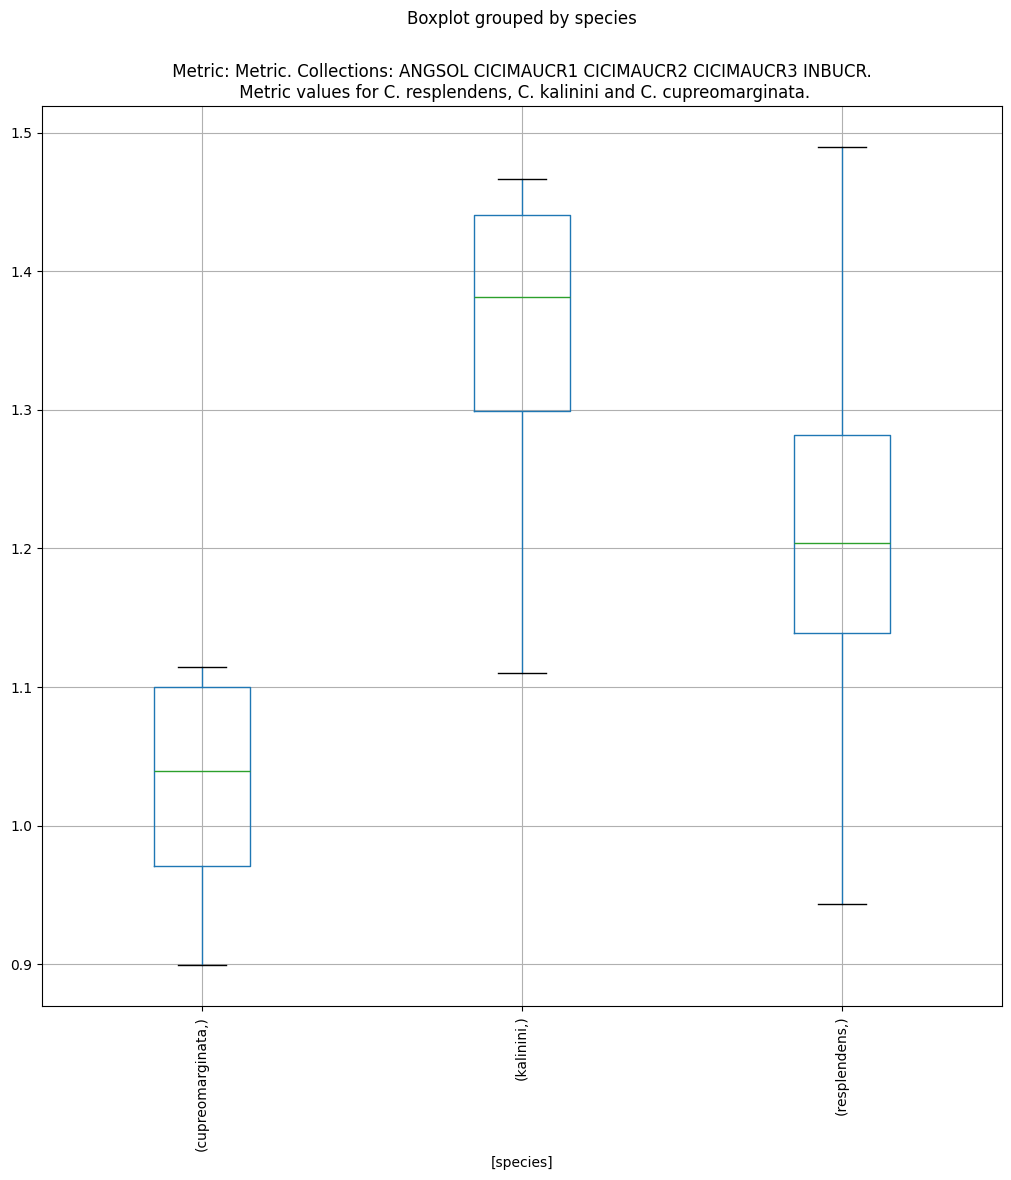

In [28]:
Metric_Testbench(Gamma_Arbitrary_Limits, all_spectra)

Directory 'C:\Users\esteb\cicima\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


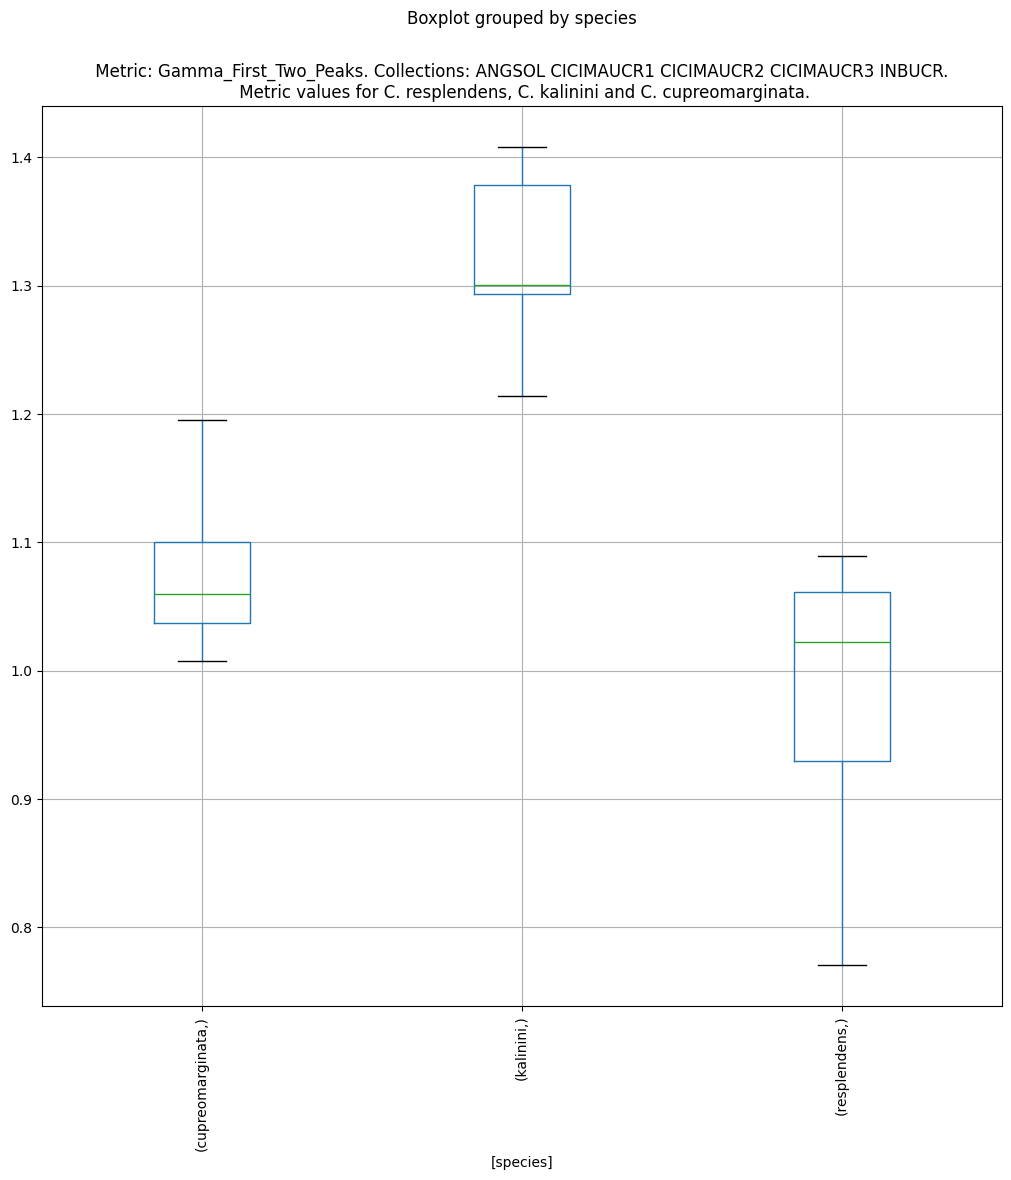

In [29]:
Metric_Testbench(Gamma_First_Two_Peaks, all_spectra)

Directory 'C:\Users\esteb\cicima\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


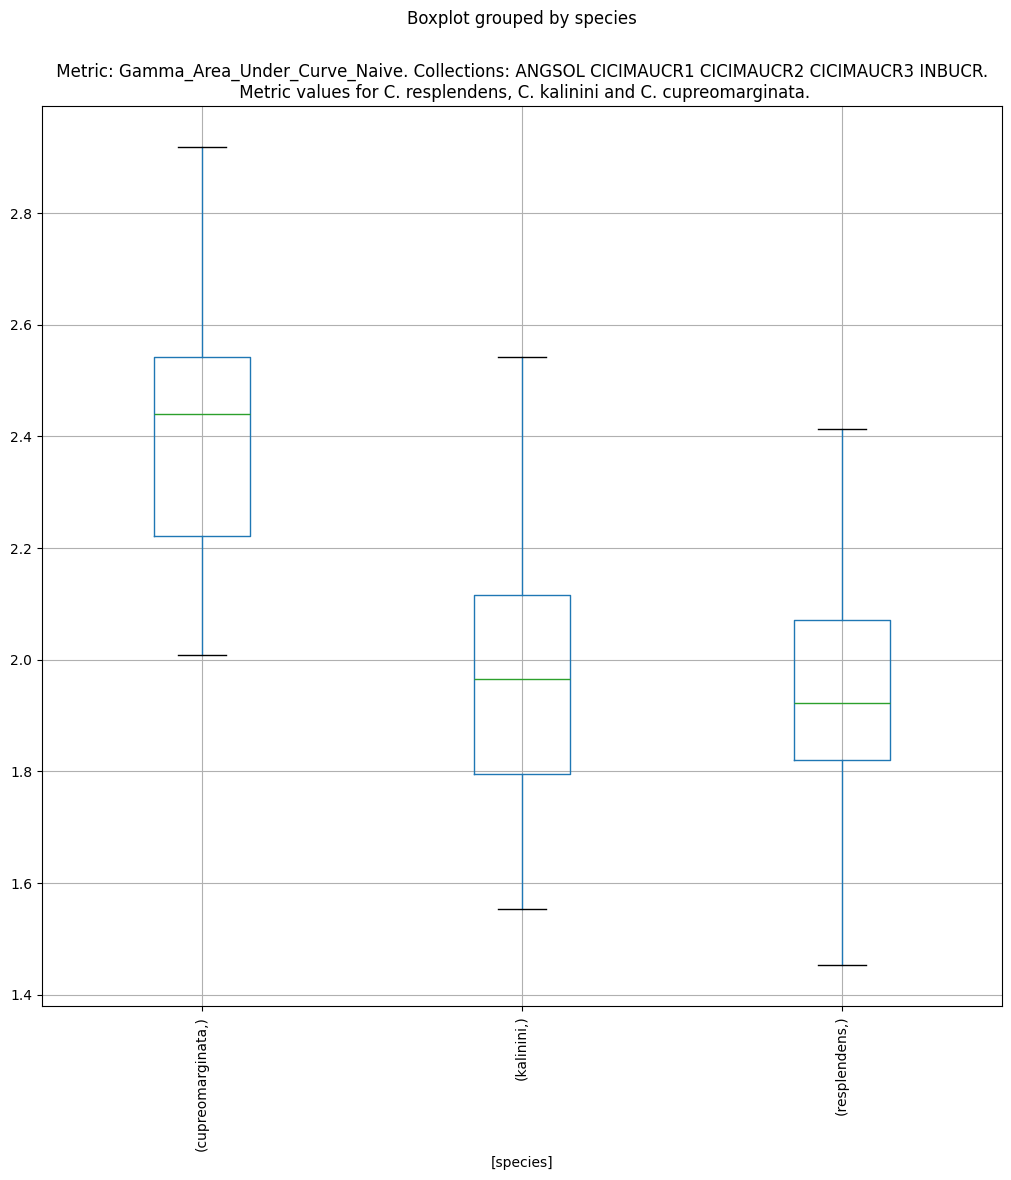

In [30]:
Metric_Testbench(Gamma_Area_Under_Curve_Naive, all_spectra)

Directory 'C:\Users\esteb\cicima\escarabajos\reports\data_analysis\report_images\gamma_image' already exists.


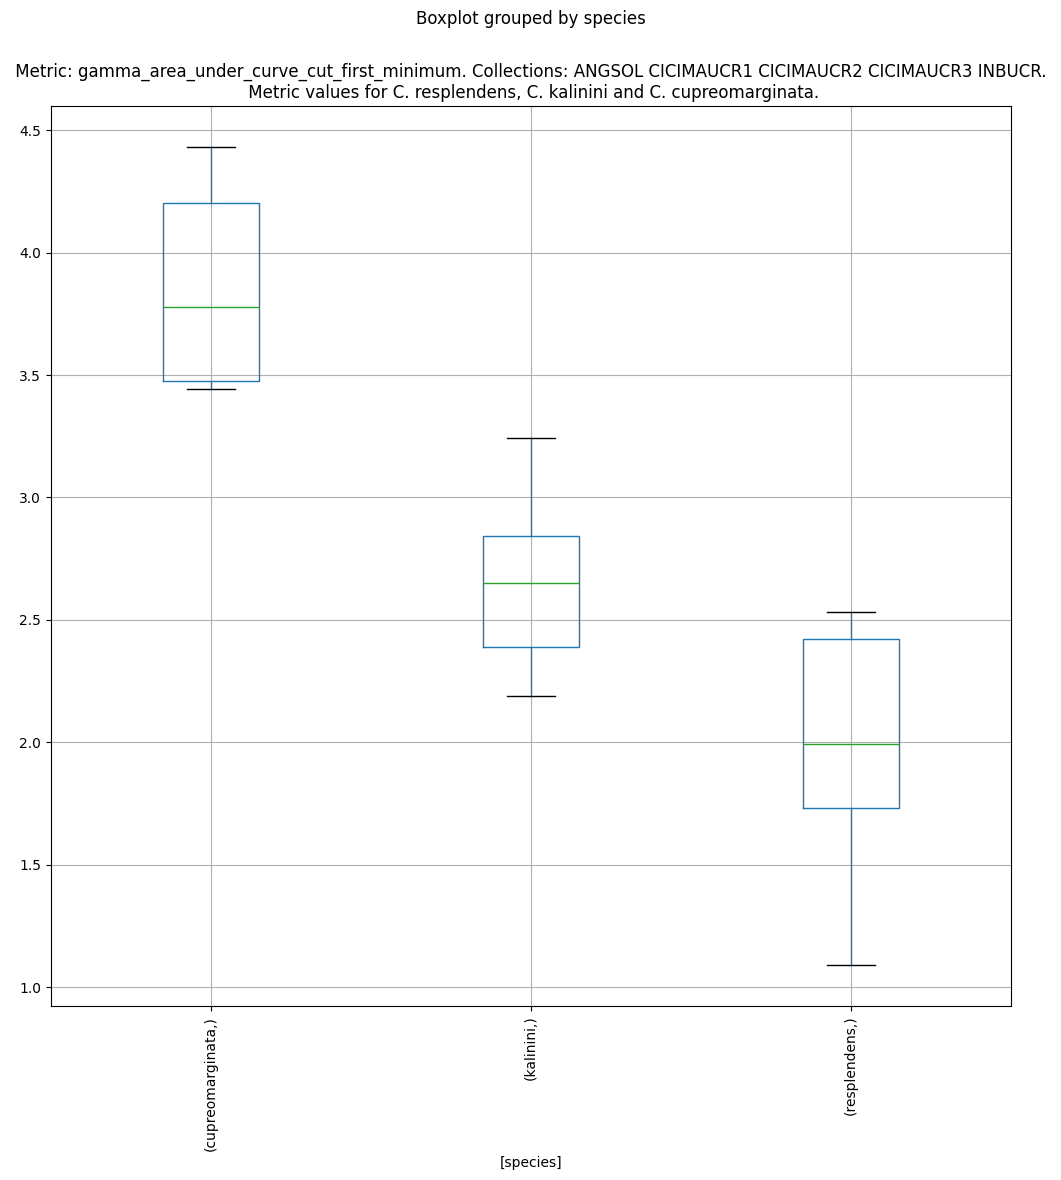

In [31]:
Metric_Testbench(Gamma_Area_Under_Curve_First_Min_Cut, all_spectra)

## Classification

In [32]:
def transpose_list(lst):
    return list(zip(*lst))

['code', 'g_arbitrary_limits', 'species', 'g_area_und_curve']
['g_arbitrary_limits', 'g_area_und_curve']


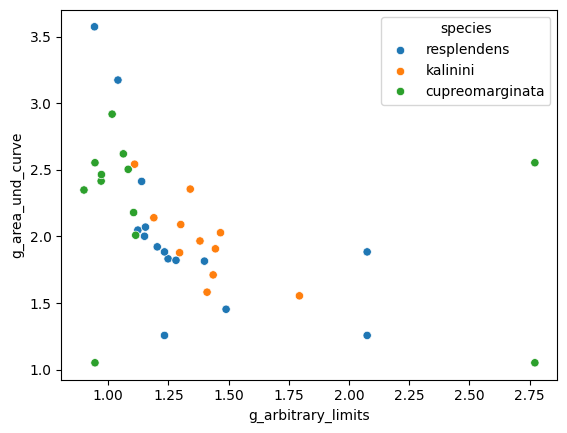

['code', 'g_arbitrary_limits', 'species', 'g_area_und_curve_first_min']
['g_arbitrary_limits', 'g_area_und_curve_first_min']


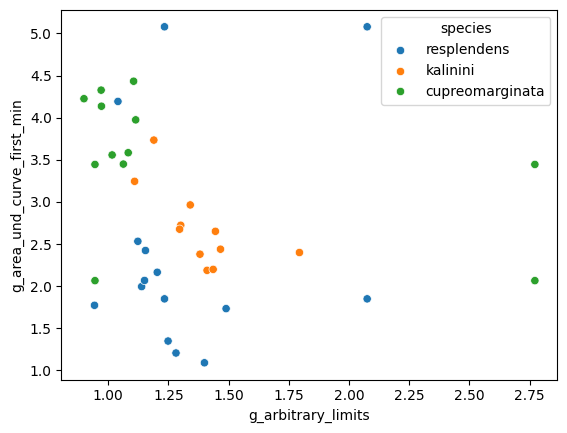

['code', 'g_first_2_peaks', 'species', 'g_area_und_curve']
['g_first_2_peaks', 'g_area_und_curve']


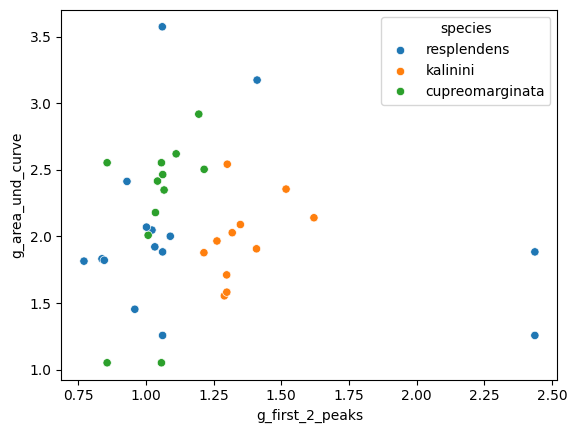

['code', 'g_first_2_peaks', 'species', 'g_area_und_curve_first_min']
['g_first_2_peaks', 'g_area_und_curve_first_min']


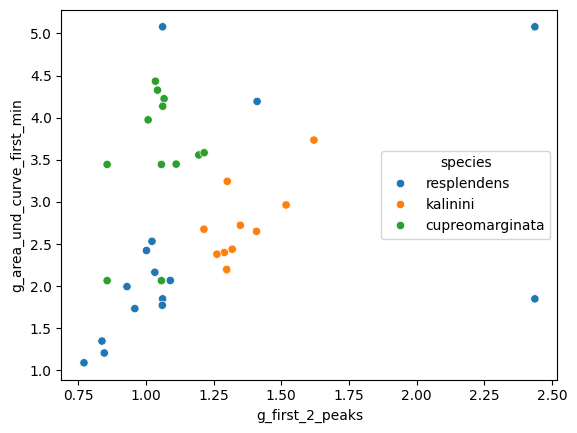

In [33]:
import seaborn as sns
gal_df = pd.DataFrame(transpose_list(gamma_arbitrary_limits_data), columns =["code", "g_arbitrary_limits", "species"]) 
gftp_df = pd.DataFrame(transpose_list(gamma_first_two_peaks_data), columns =["code", "g_first_2_peaks", "species"])
gaucfmc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_first_min_cut_data), columns =["code", "g_area_und_curve_first_min", "species"]) 
gauc_df = pd.DataFrame(transpose_list(gamma_area_under_curve_data), columns =["code", "g_area_und_curve", "species"])

def scatter_plot_2_variables(df_1, df_2):

    joint_df = pd.merge(df_1, df_2, on=["code", "species"], how="inner")
    column_list = joint_df.columns.tolist()
    print(column_list)
    column_list = [x for x in column_list if x not in ["code", "species"] ]
    print(column_list)
    plt.figure()
    sns.scatterplot(joint_df, x=column_list[0], y =column_list[1], hue="species")
    plt.show()
    
scatter_plot_2_variables(gal_df, gauc_df)
scatter_plot_2_variables(gal_df, gaucfmc_df)
scatter_plot_2_variables(gftp_df, gauc_df)
scatter_plot_2_variables(gftp_df, gaucfmc_df)
#create scatter plot
#gamma_area_under_curve_data

## Prediction one variable

In [34]:
import sys

print(sys.version_info)

sys.version_info(major=3, minor=9, micro=13, releaselevel='final', serial=0)


In [35]:
#@title Import relevant modules

from tensorflow.keras import layers


# The following lines adjust the granularity of reporting. 
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

# The following line improves formatting when ouputting NumPy arrays.
np.set_printoptions(linewidth = 200)

In [36]:
def replace_strings(lst):
    mapping = {"kalinini": 0, "resplendens": 1, "cupreomarginata": 2}
    return [mapping.get(item, item) for item in lst]

In [68]:
#gal_df 
#gftp_df 
#gaucfmc_df 
#gauc_df

def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    y = df["species"].values
    y_p = np.array(replace_strings(y))
    x = np.array(x)
    return x, y_p
    
x,y_p = get_x_y(gauc_df)

y_p

array([1, 0, 2, 0, 1, 0, 2, 0, 0, 0, 0, 2, 1, 2, 1, 2, 2, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 1, 0, 0, 0, 2, 1, 2])

In [40]:
import random

def permute_lists(list1, list2):
    # Generate a random permutation index
    permutation_index = list(range(len(list1)))
    random.shuffle(permutation_index)

    # Apply the same permutation to both lists
    permuted_list1 = [list1[i] for i in permutation_index]
    permuted_list2 = [list2[i] for i in permutation_index]

    return permuted_list1, permuted_list2
    
def partition_lists(list1, list2, fraction):
    if fraction >= 1:
        raise ValueError("Fraction must be less than 1")
    if fraction  < 0:
        raise ValueError("Fraction must be more than 0")
        
    num_elements = len(list1)
    num_selected = int(num_elements * fraction)

    # Partition elements based on the fraction
    selected_list1 = list1[:num_selected]
    selected_list2 = list2[:num_selected]
    remaining_list1 = list1[num_selected:]
    remaining_list2 = list2[num_selected:]

    return selected_list1, selected_list2, remaining_list1, remaining_list2

def get_training_and_test_data(features, labels, fraction):
    permutated_features, permuted_labels = permute_lists(features, labels)
    training_features, training_labels, test_features, test_labels = partition_lists(permutated_features, permuted_labels, fraction)
    training_features, training_labels, test_features, test_labels = np.array(training_features),  np.array(training_labels),  np.array(test_features),  np.array(test_labels)
    return training_features, training_labels, test_features, test_labels

x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.5)

In [41]:
print(x_train, y_train)

[[2.17954669]
 [2.55375778]
 [2.62053303]
 [2.14054018]
 [1.55413728]
 [2.02820757]
 [1.90725199]
 [2.00912999]
 [1.83217463]
 [1.81466535]
 [2.41597046]
 [2.46493141]
 [2.04787023]
 [2.0015494 ]
 [3.57467047]
 [2.3489074 ]
 [1.05134838]] [2 2 2 0 0 0 0 2 1 1 2 2 1 1 1 2 2]


In [42]:

def plot_curve(epochs, hist, list_of_metrics):
  """Plot a curve of one or more classification metrics vs. epoch."""  
  # list_of_metrics should be one of the names shown in:
  # https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#define_the_model_and_metrics  

  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Value")

  for m in list_of_metrics:
    x = hist[m]
    plt.plot(epochs[1:], x[1:], label=m)

  plt.legend()

print("Loaded the plot_curve function.")

Loaded the plot_curve function.


In [43]:
def create_model(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(1,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.2))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True)
                      #validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

Epoch 1/150


C:\Users\esteb\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.3088 - loss: 1.1343
Epoch 2/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3797 - loss: 1.0947 
Epoch 3/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3837 - loss: 1.1103     
Epoch 4/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4591 - loss: 1.0620 
Epoch 5/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3221 - loss: 1.0905 
Epoch 6/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5876 - loss: 1.0027 
Epoch 7/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4153 - loss: 1.1273 
Epoch 8/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4908 - loss: 1.0577 
Epoch 9/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5489 - loss: 1.0370 
Epoch 10/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5543 - loss: 1.0176 
Epoch 11/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4511 - loss: 1.0444 
Epoch 12/150
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4646 - loss: 1.0744

[1.860607385635376, 0.23529411852359772]

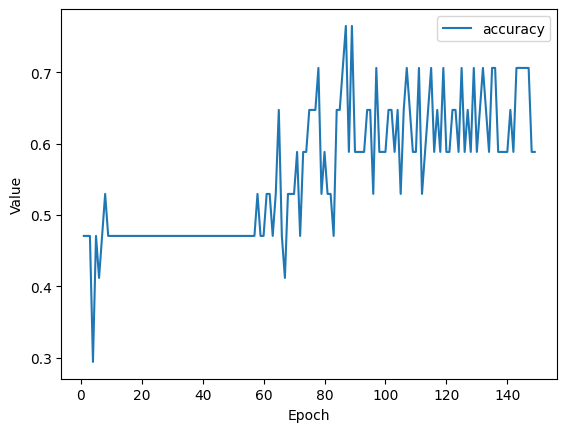

In [44]:
# The following variables are the hyperparameters.
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

# Establish the model's topography.
my_model = create_model(learning_rate)

# Train the model on the normalized training set.
#epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)

With hiperparameters: 
learning_rate = 0.008
epochs = 150
batch_size = 3
validation_split = 0.3

accuracy:
gal_df_:     0.43
gftp_df:     0.61 
gaucfmc_df:  0.77
gauc_df:     0.27

## Prediction vectorial features

In [64]:
gamma_vector_relative_reflectance_data_np = np.array(gamma_vector_relative_reflectance_data[1])
gamma_vector_relative_reflectance_data_np

array([[1.        , 0.92966156, 0.87795186, 0.84244486, 0.57505403, 0.5182256 , 0.        , 0.        , 0.        ],
       [1.        , 1.51757981, 1.11461812, 0.81330654, 0.73627098, 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.19502384, 1.17567787, 1.13509447, 0.81120859, 0.73377343, 0.        , 0.        , 0.        ],
       [1.        , 1.30028523, 1.17160619, 1.17018845, 0.76076238, 0.66803659, 0.        , 0.        , 0.        ],
       [1.        , 1.06126356, 0.44042747, 0.        , 0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.28946201, 0.52917791, 0.43903273, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 0.8562896 , 0.35553578, 0.34434818, 0.        , 0.        , 0.        , 0.        , 0.        ],
       [1.        , 1.34874782, 1.03520744, 1.03633654, 0.72769898, 0.66997526, 0.        , 0.        , 0.        ],
       [1.        , 1.62058135, 1.38605988, 1.36218964, 1.307900

In [67]:
#gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df = pd.DataFrame(transpose_list(gamma_vector_relative_reflectance_data), columns =["code", "g_arbitrary_limits", "species"])
gvrrd_df


,code,g_arbitrary_limits,species
0,ANGSOL0011,"[1.0, 0.929661563053092, 0.8779518636460617, 0...",resplendens
1,ANGSOL0012,"[1.0, 1.5175798096006232, 1.1146181236697699, ...",kalinini
2,ANGSOL0013,"[1.0, 1.195023840653329, 1.1756778665240128, 1...",cupreomarginata
3,ANGSOL0017,"[1.0, 1.3002852294600524, 1.1716061937365982, ...",kalinini
4,CICIMAUCR0104,"[1.0, 1.061263556672878, 0.44042747022178125, ...",resplendens
...,...,...,...
29,CICIMAUCR0116,"[1.0, 1.4082873370557016, 1.1843576932886888, ...",kalinini
30,CICIMAUCR0141,"[1.0, 1.2621404268543208, 1.0088889179538654, ...",kalinini
31,CICIMAUCR0158,"[1.0, 1.056971941358769, 1.0699108423449648, 1...",cupreomarginata
32,INBUCR0426,"[1.0, 1.0601788598411224, 0.8757449381547469, ...",resplendens


In [111]:
def get_x_y(df):
    columns = df.columns
    x_column_name = [x for x in columns if x not in ["code", "species"]]
    x = df[x_column_name].values
    x2 = []
    for element in x:
        xp = str(element).replace("[list(", "").replace(")]", "")
        ev = eval(xp)
        x2.append(ev)
    x2 = np.array(x2)
    
    y = df["species"].values
    y= replace_strings(y)
    y= np.array(y)
    #print(y)
    #print(df.dtypes)
    return x2, y

x,y_p = get_x_y(gvrrd_df)


In [141]:
x_train, y_train,x_test, y_test  = get_training_and_test_data(x, y_p, 0.4)

In [142]:
x_train[0]


array([1.        , 1.0326184 , 0.94881693, 0.84709939, 0.81215589, 0.45964876, 0.38291741, 0.45723744, 0.        ])

In [148]:
def create_model_2(my_learning_rate):
  """Create and compile a deep neural net."""
  
  # All models in this course are sequential.
  model = tf.keras.models.Sequential()

  # The features are stored in a two-dimensional 28X28 array. 
  # Flatten that two-dimensional array into a one-dimensional 
  # 784-element array.
  model.add(tf.keras.layers.Flatten(input_shape=(9,)))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=40, activation='relu'))

  # Define the first hidden layer.   
  model.add(tf.keras.layers.Dense(units=20, activation='relu'))

  # Define the first hidden layer.   
  #model.add(tf.keras.layers.Dense(units=20, activation='relu'))
  
  # Define a dropout regularization layer. 
  model.add(tf.keras.layers.Dropout(rate=0.4))

  # Define the output layer. The units parameter is set to 10 because
  # the model must choose among 10 possible output values (representing
  # the digits from 0 to 9, inclusive).
  #
  # Don't change this layer.
  model.add(tf.keras.layers.Dense(units=3, activation='softmax'))     
                           
  # Construct the layers into a model that TensorFlow can execute.  
  # Notice that the loss function for multi-class classification
  # is different than the loss function for binary classification.  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=my_learning_rate),
                loss="sparse_categorical_crossentropy",
                metrics=['accuracy'])
  
  return model    


def train_model(model, train_features, train_label, epochs,
                batch_size=None, validation_split=0.1):
  """Train the model by feeding it data."""

  history = model.fit(x=train_features, y=train_label, batch_size=batch_size,
                      epochs=epochs, shuffle=True,
                      validation_split=validation_split)
 
  # To track the progression of training, gather a snapshot
  # of the model's metrics at each epoch. 
  epochs = history.epoch
  hist = pd.DataFrame(history.history)

  return epochs, hist    

Epoch 1/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2577 - loss: 1.2333 - val_accuracy: 0.0000e+00 - val_loss: 1.3232
Epoch 2/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5770 - loss: 0.8896 - val_accuracy: 0.0000e+00 - val_loss: 1.2938
Epoch 3/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1407 - loss: 1.1497 - val_accuracy: 0.0000e+00 - val_loss: 1.2758
Epoch 4/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3831 - loss: 1.0290 - val_accuracy: 0.0000e+00 - val_loss: 1.2918
Epoch 5/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1977 - loss: 1.1644 - val_accuracy: 0.0000e+00 - val_loss: 1.2997
Epoch 6/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4925 - loss: 1.0497 - val_accuracy: 0.0000e+00 - val_loss: 1.2591
Epoch 7/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8631 - loss: 0.8134 - val_accuracy: 0.0000e+00 - val_loss: 1.2881
Epoch 8/150
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1719 - loss: 1.23

[5.669074058532715, 0.380952388048172]

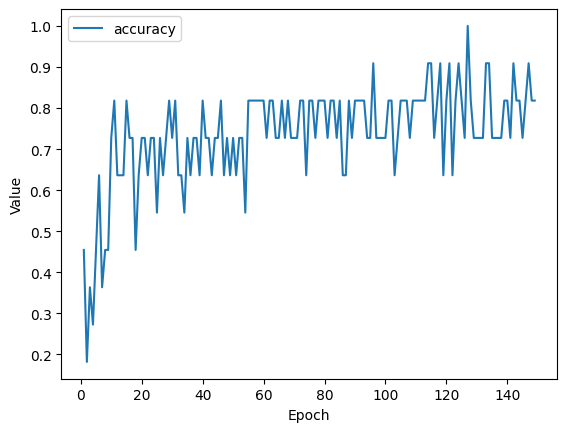

In [149]:
# The following variables are the hyperparameters.
learning_rate = 0.003
epochs = 150
batch_size = 1
validation_split = 0.0

# Establish the model's topography.
my_model = create_model_2(learning_rate)

# Train the model on the normalized training set.
epochs, hist = train_model(my_model, x_train, y_train, 
                           #epochs, batch_size, validation_split)
#epochs, hist = train_model(my_model, x_train, y_train, 
                           epochs, batch_size)

# Plot a graph of the metric vs. epochs.
list_of_metrics_to_plot = ['accuracy']
plot_curve(epochs, hist, list_of_metrics_to_plot)

# Evaluate against the test set.
print("\n Evaluate the new model against the test set:")
my_model.evaluate(x=x_test, y=y_test, batch_size=batch_size)